First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/wilson-labs/cola.git

# Diagonalizing a Hamiltonian (PDE eigenvalue problems)

## Solving the Schrodinger Equation for a 2d Harmonic oscillator

In this example, we will show how to use the CoLA library to solve for the eigenvalues and eigenfunctions of the Hamiltonian operator for a two-dimensional quantum harmonic oscillator. The Hamiltonian operator is defined as

H = -Δ/2 + V(x)

where Δ is the Laplacian operator and V(x) is the potential energy function. We will be using a discretized Laplacian on a square grid and a simple harmonic potential V(x) = x²/2.

To start, let's create a 1000 x 1000 point coordinate mesh:

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
import jax
import cola
from jax.config import config; config.update("jax_enable_x64", False)
jax.config.update('jax_platform_name', 'cpu')

N = 300
ndims = 2
grid = jnp.linspace(-30,30,N)
dx = grid[1]-grid[0]
xyz = jnp.stack(jnp.meshgrid(*(ndims * [grid])), axis=-1).reshape(-1, ndims)

Here, N is the number of points in each dimension, ndims is the number of dimensions, and grid represents the grid points from -30 to 30. dx represents the grid spacing, and xyz is an array of 2D points representing the coordinates of each point in the grid.

Next, we define the Laplacian operator. We use the same finite difference stencil as in the previous example to discretize the Laplacian.

In [2]:
def laplacian(x):
    x = x.reshape(ndims*(N,)) # unflatten to an ndims-dimensional grid
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    return sum([jnp.apply_along_axis(cderiv,i,x) for i in range(ndims)]).reshape(-1)

L = cola.ops.LinearOperator(jnp.float32, shape=(N**ndims, N**ndims), matmat=jit(vmap(laplacian, -1, -1)))

The function laplacian calculates the second derivative along each dimension and sums them up. The result is reshaped to a 1D array and returned.

Next, we define the potential function V(x) as a diagonal operator:

In [3]:
def vfn(x):
    return (x * x).sum() / 2

V = cola.ops.Diagonal(vmap(vfn)(xyz).reshape(-1))

vfn calculates the potential energy for a given point in the grid. cola.diag creates a diagonal operator with the calculated potential energy values on the diagonal. vmap is a function from the JAX library that applies the function vfn to each point in xyz.

Next, we define the Hamiltonian operator and compute its eigenvalues and eigenvectors:

In [8]:
H = cola.SelfAdjoint(-L / 2 + V)
energy_levels, eigenfunctions = cola.eig(H,26,which='SM', alg=cola.Lanczos(max_iters=1000, tol=1e-4, pbar=True))
eigenfunctions = eigenfunctions.to_dense()

Running body_fun:   0%|          | 0/100 [00:00<?,?it/s]

The Hamiltonian operator H is defined as the sum of the kinetic energy operator (-Δ/2) and the potential energy operator (V). The cola.SelfAdjoint function is used to inform CoLA that H is a symmetric operator which makes the eigenvalue calculation more efficient.

We then plot the lowest several eigenvalues:

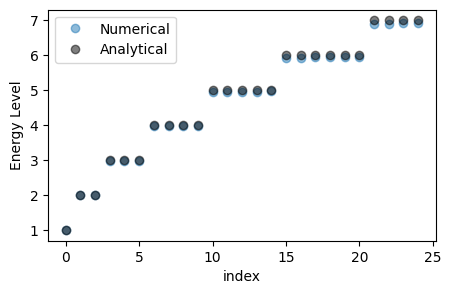

In [9]:
nm = np.stack(np.meshgrid(np.arange(10),np.arange(10)), axis=-1).reshape(-1, 2)
Enm = 1+nm[:,0]+nm[:,1]
nm = nm[Enm.argsort()]
Enm = np.sort(Enm)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize=(5, 3))
axs.plot(energy_levels[:25], 'o',alpha=0.5, label="Numerical")
axs.plot(Enm[:25], 'o', color='k',alpha=0.5, label="Analytical")
plt.legend()
plt.xlabel("index")
plt.ylabel("Energy Level")
plt.show()

Each point represents an eigenvalue, which corresponds to an energy level of the quantum harmonic oscillator. Up to errors produced by the finite boundary (at [-30,30]) and discretization, we see the familiar $E_{nm} = (1/2+n)+(1/2+m)$ energy levels for the 2d oscillator.

Lastly, we visualize the corresponding eigenfunctions:

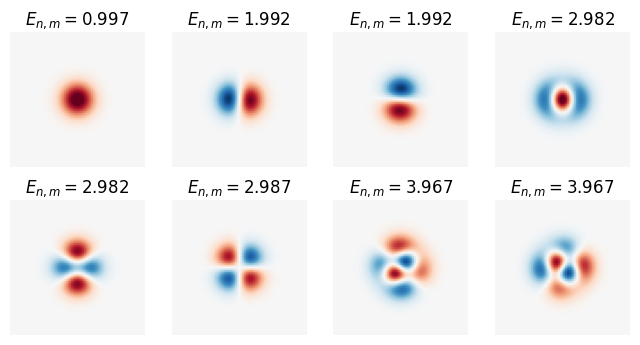

In [10]:
import numpy as np

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for i,ax in enumerate(axs.flatten()):
    l = 30
    ax.imshow(eigenfunctions[:, i].reshape(N,N)[N//2-l:N//2+l,N//2-l:N//2+l],
    extent=[grid[N//2-l],grid[N//2+l],grid[N//2+l],grid[N//2-l]],
    cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    ax.set_title(r"$E_{{{}}} ={:.3f}$".format("n,m",energy_levels[i]))
    ax.axis('off')

Each subplot represents an eigenfunction, reshaped to 2D and displayed as an image. The eigenfunctions correspond to the wave functions of the quantum harmonic oscillator at different energy levels. The color represents the value of the wave function at each point in the grid. The title of each subplot shows the corresponding eigenvalue, or energy level.

Through this example, we have shown how to solve for the energy levels and wave functions of a quantum harmonic oscillator using the CoLA library.

## 🚧 Solving Schrodinger for the Hydrogen atom in 3d 🚧